In [2]:
import numpy as np
import pandas as pd

In [3]:
data = pd.read_csv('/kaggle/input/employee-dataset/Employee.csv')
data.head()

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
0,Bachelors,2017,Bangalore,3,34,Male,No,0,0
1,Bachelors,2013,Pune,1,28,Female,No,3,1
2,Bachelors,2014,New Delhi,3,38,Female,No,2,0
3,Masters,2016,Bangalore,3,27,Male,No,5,1
4,Masters,2017,Pune,3,24,Male,Yes,2,1


In [5]:
data.shape

(4653, 9)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4653 entries, 0 to 4652
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Education                  4653 non-null   object
 1   JoiningYear                4653 non-null   int64 
 2   City                       4653 non-null   object
 3   PaymentTier                4653 non-null   int64 
 4   Age                        4653 non-null   int64 
 5   Gender                     4653 non-null   object
 6   EverBenched                4653 non-null   object
 7   ExperienceInCurrentDomain  4653 non-null   int64 
 8   LeaveOrNot                 4653 non-null   int64 
dtypes: int64(5), object(4)
memory usage: 327.3+ KB


In [7]:
for col in data:
    print(data[col].unique())

['Bachelors' 'Masters' 'PHD']
[2017 2013 2014 2016 2015 2012 2018]
['Bangalore' 'Pune' 'New Delhi']
[3 1 2]
[34 28 38 27 24 22 23 37 32 39 29 30 36 31 25 26 40 35 33 41]
['Male' 'Female']
['No' 'Yes']
[0 3 2 5 1 4 7 6]
[0 1]


In [10]:
for col in data:
    print(data[col].value_counts())
    print('------')

Education
Bachelors    3601
Masters       873
PHD           179
Name: count, dtype: int64
------
JoiningYear
2017    1108
2015     781
2014     699
2013     669
2016     525
2012     504
2018     367
Name: count, dtype: int64
------
City
Bangalore    2228
Pune         1268
New Delhi    1157
Name: count, dtype: int64
------
PaymentTier
3    3492
2     918
1     243
Name: count, dtype: int64
------
Age
26    645
28    630
27    625
25    418
24    385
29    230
30    220
37    141
36    139
34    136
38    136
40    134
32    132
39    131
31    125
33    124
35    123
41     82
22     49
23     48
Name: count, dtype: int64
------
Gender
Male      2778
Female    1875
Name: count, dtype: int64
------
EverBenched
No     4175
Yes     478
Name: count, dtype: int64
------
ExperienceInCurrentDomain
2    1087
4     931
5     919
3     786
1     558
0     355
7       9
6       8
Name: count, dtype: int64
------
LeaveOrNot
0    3053
1    1600
Name: count, dtype: int64
------


In [11]:
import seaborn as sns

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


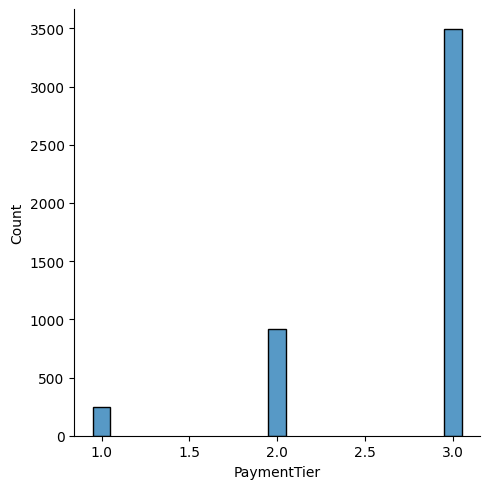

In [27]:
sns.displot(data['PaymentTier'], discrete=True, shrink=.1)

<Axes: xlabel='PaymentTier', ylabel='count'>

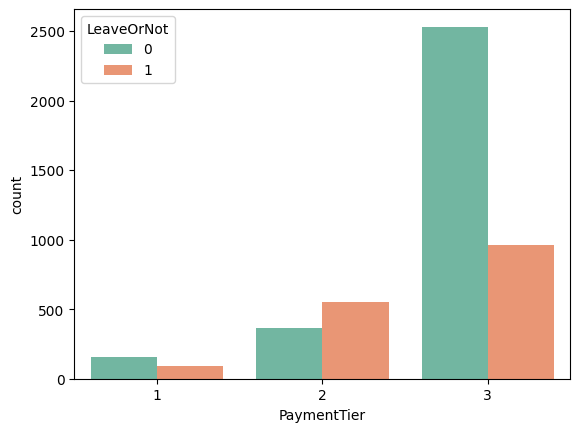

In [30]:
sns.countplot(x='PaymentTier', hue='LeaveOrNot', data=data, palette='Set2')

# **Preprocessing**

In [37]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

In [39]:
data['YearAtCompany'] = 2024 - data['JoiningYear']

In [54]:
categorical_cols = ['Education', 'City', 'Gender', 'EverBenched']  # Features to one-hot encode
numerical_cols = ['PaymentTier', 'Age', 'ExperienceInCurrentDomain', 'YearAtCompany']

In [41]:
X = data.drop(columns=['JoiningYear', 'LeaveOrNot'])
y = data['LeaveOrNot']

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [43]:
categorical_transformer = OneHotEncoder(drop='first', sparse=False)
numerical_transformer = StandardScaler()

In [55]:
preprocessor = ColumnTransformer(
    transformers = [
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

In [56]:
from sklearn import set_config

set_config(display='diagram')
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['PaymentTier', 'Age',
                                                   'ExperienceInCurrentDomain',
                                                   'YearAtCompany']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False),
                                                  ['Education', 'City',
                                                   'Gender',
                                                   'EverBenched'])]))])

In [57]:
X_train_preprocessed = pipeline.fit_transform(X_train)
X_test_preprocessed = pipeline.transform(X_test)

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [61]:
X_train_preprocessed.shape

(3722, 10)

# **Model Creation**

In [62]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.utils.class_weight import compute_class_weight

In [63]:
X_train_tensor = torch.tensor(X_train_preprocessed, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)  # Reshape for binary classification

X_test_tensor = torch.tensor(X_test_preprocessed, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

In [64]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

In [65]:
train_loader= DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [66]:
class_weights = compute_class_weight('balanced', classes=[0, 1], y=y_train)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)

In [76]:
class SimpleNN(nn.Module):
    
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        
        return x

In [77]:
input_size = X_train_tensor.shape[1]
model = SimpleNN(input_size)

In [80]:
loss_fun = nn.BCEWithLogitsLoss(pos_weight=class_weights_tensor[1])
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [81]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = loss_fun(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        predicted = (torch.sigmoid(outputs) >= 0.5).float()  # Binarize predictions
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)
        
    avg_loss = running_loss / len(train_loader)
    accuracy = correct_predictions / total_samples
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

Epoch [1/10], Loss: 0.7047, Accuracy: 0.7112
Epoch [2/10], Loss: 0.5906, Accuracy: 0.7899
Epoch [3/10], Loss: 0.5349, Accuracy: 0.8165
Epoch [4/10], Loss: 0.5061, Accuracy: 0.8254
Epoch [5/10], Loss: 0.4924, Accuracy: 0.8380
Epoch [6/10], Loss: 0.4768, Accuracy: 0.8396
Epoch [7/10], Loss: 0.4657, Accuracy: 0.8415
Epoch [8/10], Loss: 0.4585, Accuracy: 0.8455
Epoch [9/10], Loss: 0.4539, Accuracy: 0.8482
Epoch [10/10], Loss: 0.4526, Accuracy: 0.8520


In [83]:
model.eval()
test_loss = 0.0
correct_predictions = 0
total_samples = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        
        loss = loss_fun(outputs, labels)
        test_loss += loss.item()

        predicted = (torch.sigmoid(outputs) >= 0.5).float()
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)

avg_test_loss = test_loss / len(test_loader)
test_accuracy = correct_predictions / total_samples

print(f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Test Loss: 0.3972, Test Accuracy: 0.8786
